<a href="https://colab.research.google.com/github/BetterThanButter/learning_to_learn_project/blob/master/DEMO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
import random
from tqdm import notebook
import multiprocessing
import os.path
import csv
import copy
import joblib
from torchvision import datasets
import torchvision
!pip uninstall seaborn -y
!pip install seaborn==0.9.0
import seaborn as sns; 
sns.set(color_codes=True)
sns.set_style("white")

Uninstalling seaborn-0.9.0:
  Successfully uninstalled seaborn-0.9.0
  Using cached https://files.pythonhosted.org/packages/a8/76/220ba4420459d9c4c9c9587c6ce607bf56c25b3d3d2de62056efe482dadc/seaborn-0.9.0-py3-none-any.whl


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
sns.__version__

'0.9.0'

In [0]:
def switch_to_cuda(v):
    if torch.cuda.is_available():
        return v.cuda()
    return v

In [0]:
!mkdir -p _cache
cache = joblib.Memory(location='_cache', verbose=0)

Основная часть


In [0]:
def detach_var(v):
    var = switch_to_cuda(Variable(v.data, requires_grad=True))
    var.retain_grad()
    return var

def do_fit(opt_net, meta_opt, target_cls, target_to_opt, unroll, 
           optim_iterations, n_epochs, out_mul, should_train=True):
    
    if should_train:
        opt_net.train()
    else:
        opt_net.eval()
        unroll = 1
    
    target = target_cls(training=should_train)
    optimizee = switch_to_cuda(target_to_opt())
    n_params = 0

    #Find total number of parametrs (if NxN array, tha N^2)
    for p in optimizee.parameters():
        n_params += int(np.prod(p.size()))

    #Create 2 headen states and 2 cell_states
    hidden_states = [switch_to_cuda(Variable(torch.zeros(n_params, opt_net.hidden_sz))) for _ in range(2)]
    cell_states = [switch_to_cuda(Variable(torch.zeros(n_params, opt_net.hidden_sz))) for _ in range(2)]

    all_losses_ever = []
    #Обнуляем градиенты 
    if should_train:
        meta_opt.zero_grad()
    all_losses = None

    for iteration in range(1, optim_iterations + 1):
        loss = optimizee(target)
        if all_losses is None:
            all_losses = loss
        else:
            all_losses += loss
        
        all_losses_ever.append(loss.data.cpu().numpy())
        loss.backward(retain_graph=should_train)

        offset = 0
        result_params = {}
        hidden_states2 = [switch_to_cuda(Variable(torch.zeros(n_params, opt_net.hidden_sz))) for _ in range(2)]
        cell_states2 = [switch_to_cuda(Variable(torch.zeros(n_params, opt_net.hidden_sz))) for _ in range(2)]

        for name, p in optimizee.all_named_parameters():
            cur_sz = int(np.prod(p.size()))
            gradients = detach_var(p.grad.view(cur_sz, 1))
            updates, new_hidden, new_cell = opt_net(
                gradients,
                [h[offset:offset+cur_sz] for h in hidden_states],
                [c[offset:offset+cur_sz] for c in cell_states]
            )
            for i in range(len(new_hidden)):
                hidden_states2[i][offset:offset+cur_sz] = new_hidden[i]
                cell_states2[i][offset:offset+cur_sz] = new_cell[i]
            result_params[name] = p + updates.view(*p.size()) * out_mul
            result_params[name].retain_grad()
            
            offset += cur_sz
            
        if iteration % unroll == 0:
            if should_train:
                meta_opt.zero_grad()
                all_losses.backward()
                meta_opt.step()
                
            all_losses = None
                        
            optimizee = switch_to_cuda(target_to_opt(**{k: detach_var(v) for k, v in result_params.items()}))
            hidden_states = [detach_var(v) for v in hidden_states2]
            cell_states = [detach_var(v) for v in cell_states2]
            
        else:
            optimizee = switch_to_cuda(target_to_opt(**result_params))
            assert len(list(optimizee.all_named_parameters()))
            hidden_states = hidden_states2
            cell_states = cell_states2
            
    return all_losses_ever


@cache.cache
def fit_optimizer(target_cls, target_to_opt, preproc=False, unroll=20, optim_it=100, n_epochs=20, n_tests=100, lr=0.001, out_mul=1.0):
    opt_net = switch_to_cuda(Optimizer(preproc=preproc))

    #В качестве оптимизатор для оптимизатора используем Адам
    meta_opt = optim.Adam(opt_net.parameters(), lr=lr)
    
    best_net = None
    best_loss = 100000000000000000
    

    for _ in notebook.tqdm(range(n_epochs), 'epochs'):
        #Train optimizer
        for _ in notebook.tqdm(range(20), 'iterations'):
            do_fit(opt_net, meta_opt, target_cls, target_to_opt, unroll, optim_it, n_epochs, out_mul, should_train=True)
        #Evaluate optimizer
        loss = (np.mean([
            np.sum(do_fit(opt_net, meta_opt, target_cls, target_to_opt, unroll, optim_it, n_epochs, out_mul, should_train=False))
            for _ in range(n_tests)
        ]))
        #Update loss
        if loss < best_loss:
            print("Best score update:", loss, "previuous:", best_loss)
            best_loss = loss
            best_net = copy.deepcopy(opt_net.state_dict())
            
            
    return best_loss, best_net
  


# Эксперименты
1. Эксперименты с квадратичными функциями

In [0]:
class QuadraticLoss:
    def __init__(self, **kwargs):
        self.W = switch_to_cuda(Variable(torch.randn(10, 10)))
        self.y = switch_to_cuda(Variable(torch.randn(10)))
        
    def get_loss(self, theta):
        return torch.sum((self.W.matmul(theta) - self.y)**2)
    
class QuadOptimizee(nn.Module):
    def __init__(self, theta=None):
        super().__init__()
        # Note: assuming the same optimization for theta as for
        # the function to find out itself.
        if theta is None:
            self.theta = nn.Parameter(torch.zeros(10))
        else:
            self.theta = theta
        
    def forward(self, target):
        return target.get_loss(self.theta)
    
    def all_named_parameters(self):
        return [('theta', self.theta)]

Далее мы строим сам оптимизатора на основе LSTM архитектуры.

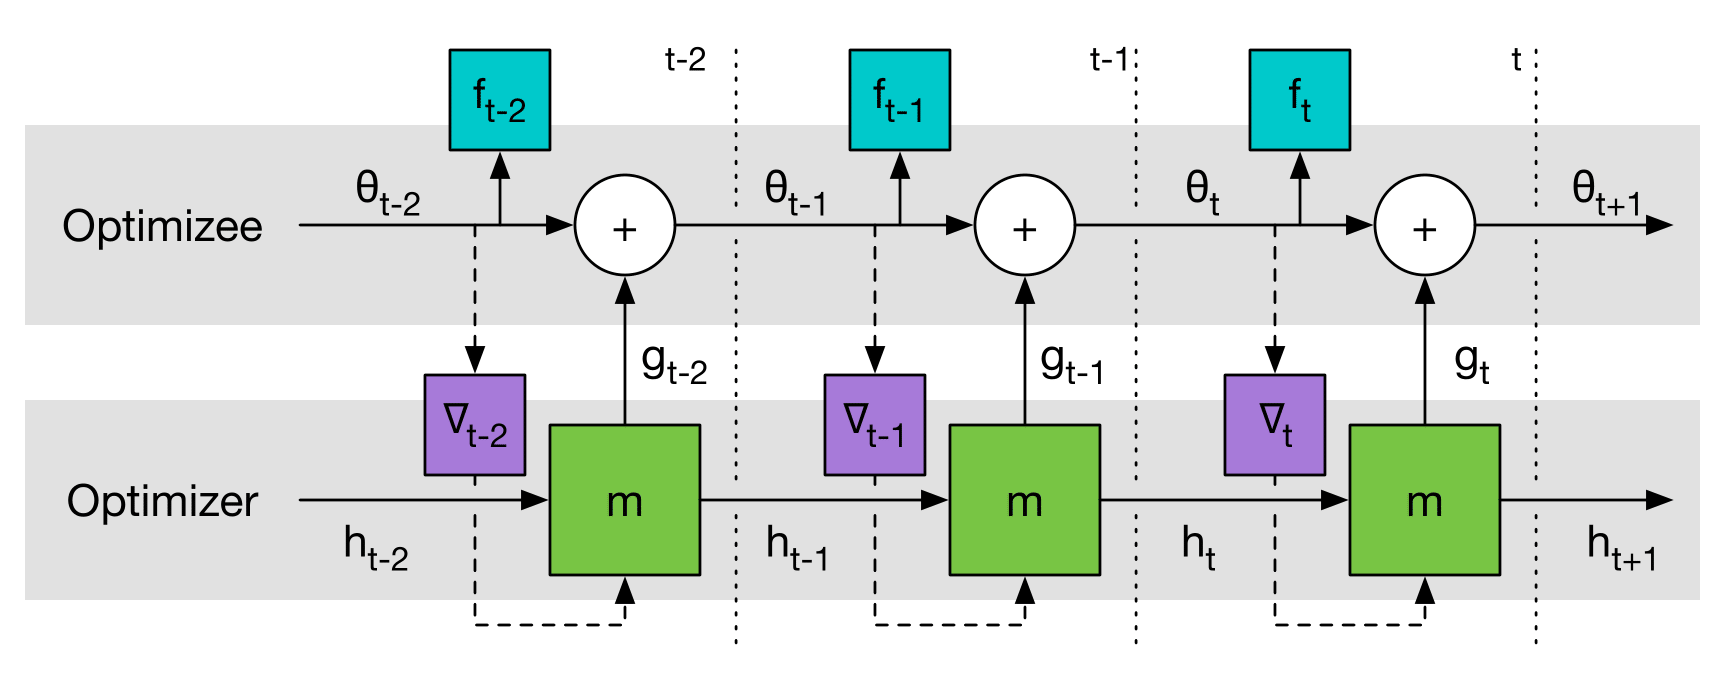

In [20]:
from IPython.display import Image
Image('computational-graph-1.png')

In [0]:

        
class Optimizer(nn.Module):
    def __init__(self, preproc=False, hidden_sz=20, preproc_factor=10.0):
        super().__init__()
        self.hidden_sz = hidden_sz
        if preproc:
            self.recurs = nn.LSTMCell(2, hidden_sz)
        else:
            self.recurs = nn.LSTMCell(1, hidden_sz)
        self.recurs2 = nn.LSTMCell(hidden_sz, hidden_sz)
        self.output = nn.Linear(hidden_sz, 1)
        self.preproc = preproc
        self.preproc_factor = preproc_factor
        self.preproc_threshold = np.exp(-preproc_factor)
        
    def forward(self, inp, hidden, cell):
        if self.preproc:
            # TODO Препроцессинг
            inp = inp.data
            inp2 = switch_to_cuda(torch.zeros(inp.size()[0], 2))
            keep_grads = (torch.abs(inp) >= self.preproc_threshold).squeeze()
            inp2[:, 0][keep_grads] = (torch.log(torch.abs(inp[keep_grads]) + 1e-8) / self.preproc_factor).squeeze()
            inp2[:, 1][keep_grads] = torch.sign(inp[keep_grads]).squeeze()
            inp2[:, 0][~keep_grads] = -1
            inp2[:, 1][~keep_grads] = (float(np.exp(self.preproc_factor)) * inp[~keep_grads]).squeeze()
            inp = switch_to_cuda(Variable(inp2))
        hidden0, cell0 = self.recurs(inp, (hidden[0], cell[0]))
        hidden1, cell1 = self.recurs2(hidden0, (hidden[1], cell[1]))
        return self.output(hidden1), (hidden0, hidden1), (cell0, cell1)
    

In [10]:
for lr in notebook.tqdm([1.0, 0.3, 0.1], 'all'):
    print('Trying lr:', lr)
    print(fit_optimizer(QuadraticLoss, QuadOptimizee, lr=lr)[0])
    
# loss, quad_optimizer = fit_optimizer(QuadraticLoss, QuadOptimizee, lr=0.003, n_epochs=100)
# print(loss)

Trying lr: 1.0



Best score update: 518175.25 previuous: 100000000000000000



Best score update: 375984.84 previuous: 518175.25



Best score update: 224482.84 previuous: 375984.84



Best score update: 102797.89 previuous: 224482.84



Best score update: 84570.29 previuous: 102797.89

84570.29
Trying lr: 0.3


/usr/local/lib/python3.6/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)



Best score update: 74136.88 previuous: 100000000000000000



Best score update: 11928.117 previuous: 74136.88



Best score update: 6108.0107 previuous: 11928.117



Best score update: 1642.1746 previuous: 6108.0107



Best score update: 1470.7662 previuous: 1642.1746



Best score update: 744.1417 previuous: 1470.7662



Best score update: 323.1824 previuous: 744.1417



Best score update: 307.69806 previuous: 323.1824



Best score update: 203.07234 previuous: 307.69806



Best score update: 202.36154 previuous: 203.07234



Best score update: 182.89064 previuous: 202.36154




182.89064
Trying lr: 0.1



Best score update: 112.998665 previuous: 100000000000000000



Best score update: 83.856766 previuous: 112.998665



Best score update: 71.285614 previuous: 83.856766



Best score update: 66.97917 previuous: 71.285614




66.97917



Решение задачи с помощью классических алгоритмов оптимизации ['ADAM', 'RMSprop', 'SGD', 'NAG']

In [0]:
@cache.cache
def fit_normal(target_cls, target_to_opt, opt_class, n_tests=100, n_epochs=100, **kwargs):
    results = []
    for i in notebook.tqdm(range(n_tests), 'tests'):
        target = target_cls(training=False)
        optimizee = switch_to_cuda(target_to_opt())
        optimizer = opt_class(optimizee.parameters(), **kwargs)
        total_loss = []
        for _ in range(n_epochs):
            loss = optimizee(target)
            total_loss.append(loss.data.cpu().numpy())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        results.append(total_loss)
    return results

def find_best_lr_normal(target_cls, target_to_opt, opt_class, **extra_kwargs):
    best_loss = 1000000000000000.0
    best_lr = 0.0
    for lr in notebook.tqdm([1.0, 0.3, 0.1], 'Learning rates'):
        try:
            loss = best_loss + 1.0
            loss = np.mean([np.sum(s) for s in fit_normal(target_cls, target_to_opt, opt_class, lr=lr, **extra_kwargs)])
        except RuntimeError:
            pass
        if loss < best_loss:
            best_loss = loss
            best_lr = lr
    return best_loss, best_lr

In [14]:
NORMAL_OPTS = [(optim.Adam, {}), (optim.RMSprop, {}), (optim.SGD, {}), (optim.SGD, {'nesterov': True, 'momentum': 0.9})]
OPT_NAMES = ['ADAM', 'RMSprop', 'SGD', 'NAG']

# NB: Парметры для метода Нестерова взяты отсюда: https://github.com/torch/optim/blob/master/nag.lua
# Все параметры, кроме lr взять дефолтными из PyTorch
for opt, kwargs in NORMAL_OPTS:
    print(find_best_lr_normal(QuadraticLoss, QuadOptimizee, opt, **kwargs))



(112.445274, 0.1)




(296.20987, 0.1)




(1000000000000000.0, 0.0)




(1000000000000000.0, 0.0)


In [16]:
loss, quad_optimizer = fit_optimizer(QuadraticLoss, QuadOptimizee, lr=0.003, n_epochs=100)


Best score update: 162.65512 previuous: 100000000000000000



Best score update: 149.54955 previuous: 162.65512



Best score update: 134.05327 previuous: 149.54955



Best score update: 115.60924 previuous: 134.05327



Best score update: 113.9954 previuous: 115.60924



Best score update: 104.14279 previuous: 113.9954



Best score update: 103.79171 previuous: 104.14279



Best score update: 89.99206 previuous: 103.79171



Best score update: 86.00789 previuous: 89.99206



Best score update: 75.54021 previuous: 86.00789



Best score update: 72.88118 previuous: 75.54021



Best score update: 71.7606 previuous: 72.88118



Best score update: 71.52715 previuous: 71.7606



Best score update: 65.97029 previuous: 71.52715



Best score update: 60.029457 previuous: 65.97029



Best score update: 51.42427 previuous: 60.029457


/usr/local/lib/python3.6/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


In [0]:
QUAD_LRS = [0.1, 0.03, 0.01, 0.01]
fit_data = np.zeros((100, 100, len(OPT_NAMES) + 1))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    np.random.seed(0)
    fit_data[:, :, i] = np.array(fit_normal(QuadraticLoss, QuadOptimizee, opt, lr=lr, **extra_kwargs))

opt = switch_to_cuda(Optimizer())
opt.load_state_dict(quad_optimizer)
np.random.seed(0)
fit_data[:, :, len(OPT_NAMES)] = np.array([do_fit(opt, None, QuadraticLoss, QuadOptimizee, 1, 100, 100, out_mul=1.0, should_train=False) for _ in range(100)])

/usr/local/lib/python3.6/dist-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


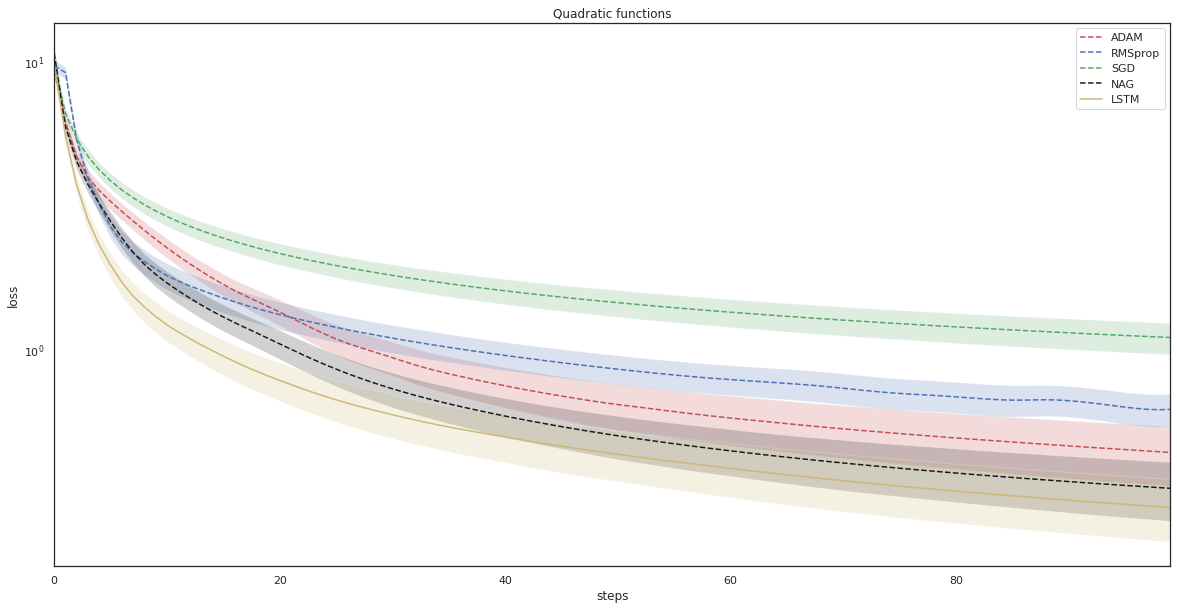

In [18]:
f, ax = plt.subplots(figsize=(20, 10))
ax = sns.tsplot(data=fit_data[:, :, :], condition=OPT_NAMES+['LSTM'], linestyle='--', color=['r', 'b', 'g', 'k', 'y'], ax=ax)
ax.lines[-1].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('Quadratic functions')
plt.show()